In [1]:
tf_version = !pip3 show tensorflow | grep Version
if '2.2' not in tf_version[0]:
  print("downgrading tensorflow")
  !pip3 uninstall --yes tensorflow
  !pip3 install tensorflow==2.2

keras_version = !pip3 show keras | grep Version
if '2.3.1' not in keras_version[0]:
  print("downgrading keras")
  !pip3 uninstall --yes keras
  !pip3 install keras==2.3.1

downgrading tensorflow
Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 84kB/s 
     |████████████████████████████████| 3.0MB 43.6MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
downgrading keras
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 7.8MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 


In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt 
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

try:
    import dill as pickle
except ImportError:
    import pickle

Using TensorFlow backend.


In [3]:
try:
    import dill as pickle
except ImportError:
    import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    
    text = file.read() 
    file.close()
    return text

base_dir = "/content/drive/My Drive/MB/"
dataset_dir = "/content/drive/My Drive/"
descriptions_filename = dataset_dir + "Flickr8k_text/Flickr8k.token.txt"
# load descriptions
descriptions_doc = load_doc(descriptions_filename)
print(descriptions_doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [7]:
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open(base_dir + "train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000


In [8]:
# Loading embedding_matrix
embedding_matrix = load(open(base_dir + "Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

Embedding Matrix shape = (2064, 200)


In [9]:
# Loading wordtoix
wordtoix = load(open(base_dir + "wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


Data Generator

In [10]:
max_length = 34 # computer from file 2
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [11]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
    return X1, X2, y

Defining the Model

In [13]:
max_length = 35 
vocab_size = embedding_matrix.shape[0]
steps = len(train_descriptions)//number_pics_per_bath
embedding_dim = embedding_matrix.shape[1]
max_length,vocab_size ,embedding_dim

(35, 2064, 200)

In [14]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
my_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [15]:
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      412800      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [16]:
my_model.layers[2]

In [17]:
my_model.layers[2].set_weights([embedding_matrix])
my_model.layers[2].trainable = False

In [18]:
my_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

In [21]:
starting_epoch = 0
if starting_epoch > 0:
  my_model = load_model(base_dir + 'clean_model_' + str(starting_epoch-1) + '.h5')
epochs = 40
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [23]:
for i in range(starting_epoch, starting_epoch + epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    my_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # my_model.save(base_dir + 'clean_model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 98s 98ms/step - loss: 4.4712
Epoch 1/1
1000/1000 [==============================] - 97s 97ms/step - loss: 3.9358
Epoch 1/1
1000/1000 [==============================] - 96s 96ms/step - loss: 3.7009
Epoch 1/1
1000/1000 [==============================] - 96s 96ms/step - loss: 3.5396
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 3.4191
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 3.3186
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 3.2369
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 3.1704
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 3.1143
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 3.0686
Epoch 1/1
1000/1000 [==============================] - 94s 94ms/step - loss: 3.0251
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss:

In [25]:
my_model.save(base_dir + 'clean_model_39.h5')

In [ ]:
model = load_model(base_dir + 'clean_model_39.h5')

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      318200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
with open(base_dir + "encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
# Loading wordtoix
wordtoix = load(open(base_dir + "wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 1590


In [ ]:
ixtoword = {}
for word, i in wordtoix.items():
    ixtoword[i] = word

In [ ]:
Directory_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
max_length = 35

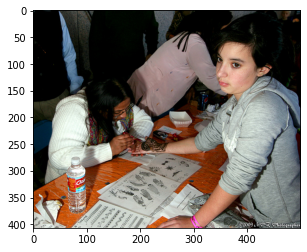

Greedy: man sit stool
Refs: 
 A girl is getting a tattoo on her hand .
A girl sits patiently as another one draws henna on her .
The girl is standing as the other girl with glasses works on her hand painting .
The woman in the white sweater is painting a tattoo on the teenager 's hand .
Two girls at a table with papers between them .


In [ ]:
z = 123
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(Directory_path+pic)
plt.imshow(x)
plt.show()
predicted = greedySearch(image)
print("Greedy:",predicted)
print("Refs: \n", '\n'.join(descriptions[pic.split('.')[0]]))

In [ ]:
from tqdm.notebook import tqdm

train_predictions = {img_id: greedySearch(img_features.reshape((1, 2048))) for img_id, img_features in tqdm(train_features.items())}
pickle.dump(train_predictions, open(base_dir + 'train_predictions.pkl', 'wb'))

test_predictions = {img_id: greedySearch(img_features.reshape((1, 2048))) for img_id, img_features in tqdm(test_features.items())}
pickle.dump(test_predictions, open(base_dir + 'test_predictions.pkl', 'wb'))
